# Imports

In [3]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import string

# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

#import nltk
#nltk.download('stopwords')

In [5]:
tweets_text_label = pd.read_json('../data/MMHS150K_GT.json', orient='index', convert_axes=False, convert_dates=False, keep_default_dates=False) #
tweets_text_label = tweets_text_label.drop(columns=['img_url', 'tweet_url'])
tweets_text_label.head(5)

,labels,tweet_text,labels_str
1114679353714016256,"[4, 1, 3]",@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[Religion, Racist, Homophobe]"
1063020048816660480,"[5, 5, 5]",My horses are retarded https://t.co/HYhqc6d5WN,"[OtherHate, OtherHate, OtherHate]"
1108927368075374593,"[0, 0, 0]",“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[NotHate, NotHate, NotHate]"
1114558534635618305,"[1, 0, 0]",RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[Racist, NotHate, NotHate]"
1035252480215592966,"[1, 0, 1]",“EVERYbody calling you Nigger now!” https://t....,"[Racist, NotHate, Racist]"


# Multimodal Hate Speech

# Size

In [6]:
print(f'For the training we have {len(tweets_text_label)} unique annotated tweets with text and image data. Taking up over 6GB of Disk Space')

For the training we have 149823 unique annotated tweets with text and image data. Taking up over 6GB of Disk Space


## Label Distribution
The dataset distinguishes between 0 - NotHate, 1 - Racist, 2 - Sexist, 3 - Homophobe, 4 - Religion, 5 - OtherHate for our purpose we shrink it to 0 - NotHate, 1 - Hate. <br>
Each tweet in the dataset was annotated by 3 different Annotators. Therefore we follow the majority of Voters.

In [7]:
dct = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1}
tweets_text_label['labels'] = tweets_text_label['labels'].apply(lambda x: [*map(dct.get, x)])

In [8]:
tweets_text_label['majority_label'] = tweets_text_label.apply(lambda x: Counter(x['labels']).most_common()[0][0], axis=1)

<AxesSubplot:>

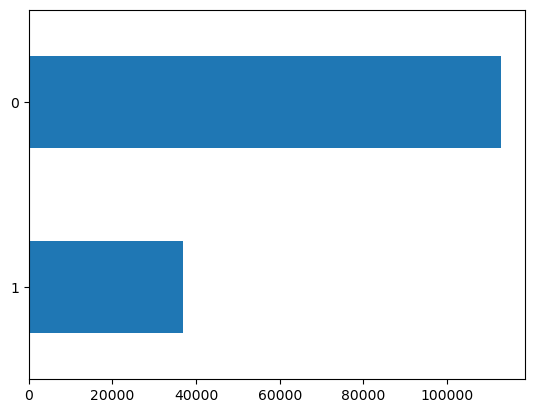

In [9]:
tweets_text_label['majority_label'].value_counts().sort_values().plot(kind = 'barh')

# Text Data

Länge der Texte

In [10]:
tweets_text_label['len_text'] = tweets_text_label['tweet_text'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))
tweets_text_label.groupby(['majority_label'])['len_text'].mean()

majority_label
0    9.481037
1    9.458386
Name: len_text, dtype: float64

Top Words ohne Stopwords

In [11]:
tweets_text_label["tweet_text_removed_stopwords"] = tweets_text_label["tweet_text"].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop)]))

In [12]:
# Most common words overall.
Counter(" ".join(tweets_text_label["tweet_text_removed_stopwords"]).split()).most_common(10)

[('nigga', 69328),
 ('like', 10656),
 ('cunt', 10386),
 ('ass', 5955),
 ('dyke', 5939),
 ('twat', 5320),
 ('got', 5098),
 ('i’m', 5051),
 ('fuck', 4937),
 ('get', 4606)]

In [42]:
# Most common words for NotHate.
tweets_text_label_0 = tweets_text_label[tweets_text_label['majority_label'] == 0]
Counter(" ".join(tweets_text_label_0["tweet_text_removed_stopwords"]).split()).most_common(10)

[('nigga', 60254),
 ('like', 8289),
 ('cunt', 7092),
 ('ass', 4636),
 ('got', 4090),
 ('i’m', 4027),
 ('dyke', 3880),
 ('twat', 3814),
 ('fuck', 3681),
 ('get', 3474)]

In [41]:
# Most common words for Hate.
tweets_text_label_1 = tweets_text_label[tweets_text_label['majority_label'] == 1]
Counter(" ".join(tweets_text_label_1["tweet_text_removed_stopwords"]).split()).most_common(10)

[('nigga', 9074),
 ('cunt', 3294),
 ('faggot', 2690),
 ('nigger', 2398),
 ('like', 2367),
 ('retarded', 2200),
 ('dyke', 2059),
 ('white', 1682),
 ('twat', 1506),
 ('retard', 1446)]

# Image Data

In [43]:
tweets_text_label

,labels,tweet_text,labels_str,majority_label,len_text,tweet_text_removed_stopwords
1114679353714016256,"[1, 1, 1]",@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[Religion, Racist, Homophobe]",1,2,@friskdontmiss nigga https://t.co/casalwepue
1063020048816660480,"[1, 1, 1]",My horses are retarded https://t.co/HYhqc6d5WN,"[OtherHate, OtherHate, OtherHate]",1,4,horses retarded https://t.co/hyhqc6d5wn
1108927368075374593,"[0, 0, 0]",“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[NotHate, NotHate, NotHate]",0,8,“nigga momma youngboy spitting real shit nigga...
1114558534635618305,"[1, 0, 0]",RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[Racist, NotHate, NotHate]",0,9,rt xxsugvngxx: ran holy nigga today 😭😭😭😭 https...
1035252480215592966,"[1, 0, 1]",“EVERYbody calling you Nigger now!” https://t....,"[Racist, NotHate, Racist]",1,3,“everybody calling nigger now!” https://t.co/6...
...,...,...,...,...,...,...
1114170734472048640,"[1, 1, 0]",@svdate @gtconway3d I would just say hes Donny...,"[Sexist, OtherHate, NotHate]",1,9,@svdate @gtconway3d would say hes donny retard...
1110368198786846720,"[0, 0, 0]",@Cheftime_Dev congrats my nigga keep on grindi...,"[NotHate, NotHate, NotHate]",0,6,@cheftime_dev congrats nigga keep grinding htt...
1106941858540851200,"[0, 1, 0]",My nigga big shitty https://t.co/e0snJGBgH9,"[NotHate, Racist, NotHate]",0,4,nigga big shitty https://t.co/e0snjgbgh9
1105268309233188865,"[1, 0, 0]",did she just say “my nigga” to Rich? &amp; she...,"[Racist, NotHate, NotHate]",0,15,say “my nigga” rich? &amp; said anger? mmph. #...
